# Описание проекта: Обнаружение мошеннических транзакций с кредитными картами

## Общая информация
Данные содержат транзакции по кредитным картам за 2 дня в сентябре 2013 года. Датасет характеризуется **сильным дисбалансом классов**: большинство транзакций легитимные, а мошеннические составляют менее 1% от общего объема.

**Цель**: Построить модель бинарной классификации для обнаружения мошеннических операций.

## Описание признаков
| Признак  | Тип данных | Описание                                                                 |
|----------|------------|-------------------------------------------------------------------------|
| **Time** | `float`    | Время транзакции в секундах относительно первой транзакции в датасете   |
| **V1-V28** | `float`  | Анонимизированные признаки, полученные после PCA-преобразования. Нормализованы (диапазон: [-10, 10]) |
| **Amount** | `float` | Сумма транзакции в долларах                                             |
| **Class** | `int`    | Целевая метка: `0` - легитимная транзакция, `1` - мошенническая         |

## Статистика классов
```python
Легитимные транзакции - legit (Class = 0): 284,315 (99.83%)
Мошеннические транзакции - fraud (Class = 1): 492 (0.17%)

In [64]:
# Основные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Модели
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Метрики
from sklearn.metrics import classification_report, precision_recall_curve, precision_recall_curve, average_precision_score, roc_curve, auc

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Кросс-валидация и разбиние данных
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict

## Датафрейм

In [5]:
df = pd.read_csv('creditcard.csv')
pd.set_option('display.max_columns', None)  # Показывать все колонки

Датафрейм содержит признаки полученные после PCA преобразования V1-V28, Time - время в секундах в течение 50ч., Amount - сумма транзакций.


In [138]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Анализ датасета

Построим график дисбаланса классов, для наглядности проблемы задачи.

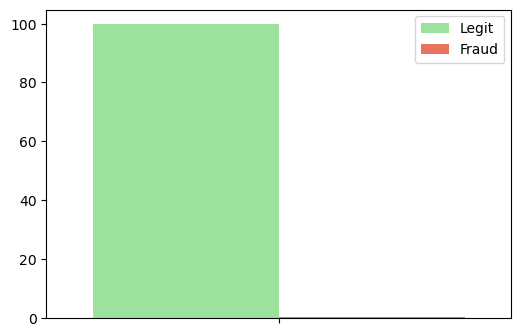

In [5]:
plt.figure(figsize=(6,4))
sns.barplot(hue=['Legit', 'Fraud'], y=[legit_percent, fraud_percent], palette=['Lightgreen', 'Tomato'])
plt.show()

Здесь я решил решил посмотреть зависимость между Суммой транзакций и Целевой переменной. Случайно заметил, что все fraud транзакции не привышали ~3k$

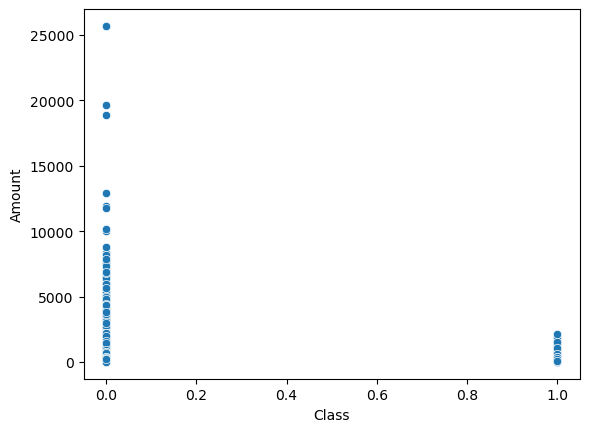

In [6]:
sns.scatterplot(y='Amount', x='Class', data=df)  # корреляция между Class и Amount
plt.show()

Тут я решил найти максимальную сумму fraud транзакции

In [7]:
max_fraud_amount = df[df['Class'] == 1]['Amount'].max() # максимальное значение суммы мошеннической операции 
max_fraud_amount

2125.87

Построив график распределения транзакций по времени, можно увидеть 2 горба. Эти 'горбы' - дневное время, в которое обычно совершается больше транзакций

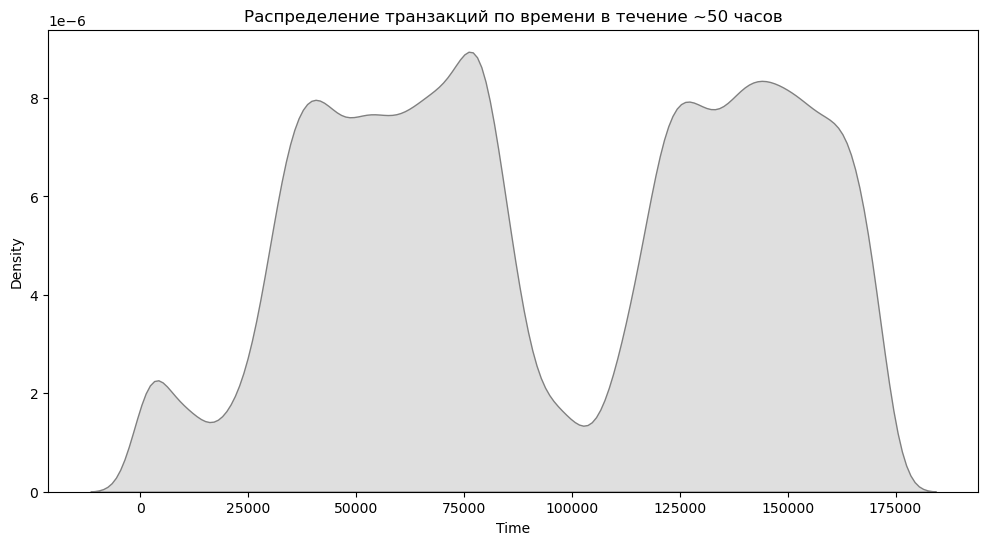

In [8]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x = 'Time',fill=True, color='grey')
plt.title('Распределение транзакций по времени в течение ~50 часов')
plt.show()

Данный график показывает распределение сумм транзакций. Много транзакций на небольшие суммы, что логично.

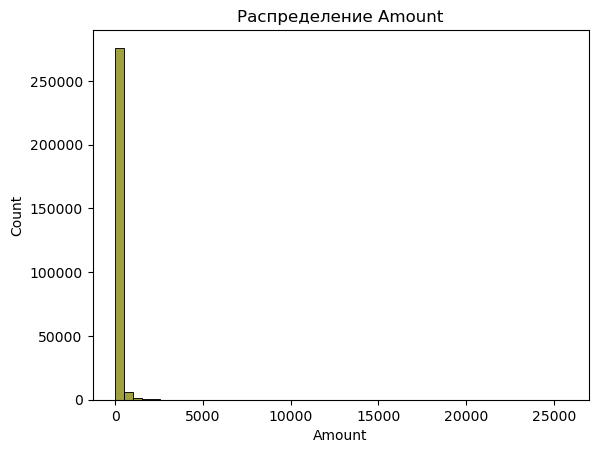

In [9]:
sns.histplot(df['Amount'], bins=50, color='olive')
plt.title('Распределение Amount')
plt.show()

- Данные v1-v28 имеют диапазон [-10; 10], Но Amount и Time сильно больше, по-хорошему их необходимо мастштабировать, чтобы модель не присваивала большие веса этим признакам.
- Как выяснилось на практике, масштабирование данных для логистической регрессии не несет никакого эффекта, подозреваю это происходит из-за сигмойды.
- В процессе реализации проекта, я принял решение обучать только на v1-v28 признаках, тк это не противоречить правилам соревнования на Kagle и проведя тесты, метрики моделей обученных на `v1-v28 + Amount + Time`, не отличались от моделей обученных только на `v1-v28`
- Также в процессе реализации выяснилось, что многие используют корреляционную матрицу для отбора признаков, вычисление корреляций между показателями для данного набора - неверно. Показатели получены после алгоритма PCA, который по определению создаёт нескоррелированные показатели.

#### Про выбор моделей
- Я выбрал логистическую регрессию, тк она понятна бизнесу (не черный ящик, как нейросеть), удобно интегрируется в прод, проста в реализации и отлично подходит для бинарной классификации.
- XGBoost

#### Про выбор метрик 
- Так как наша задача находить ВСЕ fraud транзакции, мы можем пожертвовать метрикой precision, то есть какие-то легит транзакции предсказывать как - fraud. НО, если модель будет классифицировать все транзакции как fraud, от модели не будет толка. Значит нужно найти баланс между precision и recall. Для такой задачи подобрана метрика `PR-AUC`.
#### PR-AUC
Площадь под Precision-Recall кривой:
$$ \text{PR-AUC} = \int_{0}^{1} P(r) \, dr $$
$P(r)$ — функция, описывающая Precision (точность) в зависимости от Recall (полноты 
r) при изменении порога классификации.

## Подготовка данных к обучению

Разбиение датасета на обучающие и тестовые наборы данных.

In [6]:
X = df.drop(['Class', 'Time', 'Amount'], axis=1)
y = df['Class']
print(X, y)
print(len(X) == len(y)) # проверка корректности размеров наших данных

               V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10       V11       V12       V13  \
0       0.239599  0.098698  0.363787  0.090794 -0.55160

Классическое разбиение данных 75% - Train, 25% - Test.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

## Функция для оценки моделей

Функция реализована под это проект, для удобства проверки влияния гиперпараметров (вручную). Перебор через GreadSearch или Бейсовский оптимизатор из Optuna - трубет больших вычислительных мощностей и дополнительных функций проверки совместимости гиперпараметров(l1, l2 - несовместимы с некоторыми солверами, подбор коэфициентов тоже самое...).

"""

    Функция для оценки классификаторов.
    с возможностью подбора порога классификации и построения PR-кривой.
    
    Параметры:
    
    model: обученная модель с методами predict_proba и/или predict
    X_train, y_train: обучающие данные
    X_test, y_test: тестовые данные
    threshold: вероятностный порог для классификации (если None, используется стандартный predict)
    plot_pr_curve: строить ли PR-кривую (по умолчанию True)
    
"""

In [41]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=None):
    """
    Функция для оценки классификаторов.
    с возможностью подбора порога классификации и построения PR-кривой.
    
    Параметры:
    
    model: обученная модель с методами predict_proba и/или predict
    X_train, y_train: обучающие данные
    X_test, y_test: тестовые данные
    threshold: вероятностный порог для классификации (если None, используется стандартный predict)
    plot_pr_curve: строить ли PR-кривую (по умолчанию True)
    
    """
    
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    
    if threshold is not None:
        train_pred = (train_proba >= threshold).astype(int)
        test_pred = (test_proba >= threshold).astype(int)
    else:
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

    train_metrics = {
        'pr_auc': average_precision_score(y_train, train_proba),
        'classification_report': classification_report(y_train, train_pred, zero_division=0)
    }
    
    test_metrics = {
        'pr_auc': average_precision_score(y_test, test_proba),
        'classification_report': classification_report(y_test, test_pred, zero_division=0)
    }
    
    print('TRAIN')
    if threshold is not None:
        print(f"Использованный порог: {threshold}")
    print(f"PR-AUC: {round(train_metrics["pr_auc"], 4)}")
    print(train_metrics['classification_report'])
    
    print('TEST')
    if threshold is not None:
        print(f"Использованный порог: {threshold}")
    print(f"PR-AUC: {round(test_metrics["pr_auc"], 4)}")
    print(test_metrics['classification_report'])
    
    # PR-кривая
    precision_train, recall_train, _ = precision_recall_curve(y_train, train_proba)
    precision_test, recall_test, _ = precision_recall_curve(y_test, test_proba)
        
    plt.figure(figsize=(8, 6))
        
    plt.plot(recall_train, precision_train, label=f'Train (PR-AUC = {round(train_metrics["pr_auc"], 4)})')
    plt.plot(recall_test, precision_test, label=f'Test (PR-AUC = {round(test_metrics["pr_auc"], 4)})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

## Логистическая регрессия


Для начала нужно построить модель логистической регрессии без параметров, чтобы посмотреть в чем проблема и насколько сильно дисбаланс классов влияет на модель.

In [8]:
logr = LogisticRegression(n_jobs=-1)

In [11]:
logr.fit(X=X_train,y=y_train)

LogisticRegression(n_jobs=-1)

TRAIN
PR-AUC: 0.7539
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213238
           1       0.86      0.60      0.71       367

    accuracy                           1.00    213605
   macro avg       0.93      0.80      0.86    213605
weighted avg       1.00      1.00      1.00    213605

TEST
PR-AUC: 0.7892
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.88      0.62      0.72       125

    accuracy                           1.00     71202
   macro avg       0.94      0.81      0.86     71202
weighted avg       1.00      1.00      1.00     71202



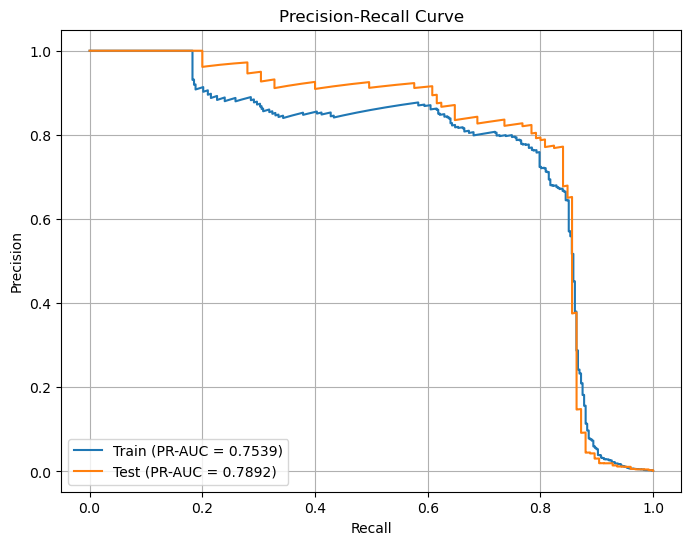

None


In [120]:
logr_eval = evaluate_model(logr, X_train, y_train, X_test, y_test)
print(logr_eval)

### Проблема
**PR-AUC** = 0.75 - выглядит не так плохо, НО
**Recall = 0.6 для fraud** - это означает:
- Модель пропускает **40% мошеннических операций**
- Для бизнеса это **неприемлемо** - мы хотим находить ВСЕ fraud-транзакции

### Задача
**Поднять recall для fraud** насколько это возможно при критическом дисбалансе.

## Модель логистической регрессии со взвешиванием классов

#### Решение низкого recall - применение дополнительного штрафа (взвешивание класса) к функции потерь.
$$
w_j = \frac{n\_samples}{n\_classes \times n\_samples_j}
$$

где:
- $w_j$ - вес класса $j$
- $n\_samples$ - общее количество наблюдений
- $n\_classes$ - количество уникальных классов
- $n\_samples_j$ - количество наблюдений класса $j$

## Функции потерь с учетом весов классов

#### Обычная лог-функция потерь 

$$
\text{Loss} = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log(p_i) + (1-y_i) \log(1-p_i)\right]
$$

где:
- $y_i$ - истинный класс (0 или 1)
- $p_i$ - предсказанная вероятность класса 1
- $N$ - количество образцов

### Взвешенная функция потерь с `class_weight='balanced'`

$$
\text{Loss} = -\frac{1}{N}\sum_{i=1}^N w_{y_i} \left[y_i \log(p_i) + (1-y_i) \log(1-p_i)\right]
$$

In [12]:
logr_model_balanced = LogisticRegression(
        class_weight='balanced',
        n_jobs=-1,
        max_iter=150
)

In [13]:
logr_model_balanced.fit(X=X_train,y=y_train)

LogisticRegression(class_weight='balanced', max_iter=150, n_jobs=-1)

TRAIN
PR-AUC: 0.7212
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    213238
           1       0.06      0.93      0.12       367

    accuracy                           0.98    213605
   macro avg       0.53      0.95      0.55    213605
weighted avg       1.00      0.98      0.99    213605

TEST
PR-AUC: 0.7661
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71077
           1       0.06      0.90      0.12       125

    accuracy                           0.98     71202
   macro avg       0.53      0.94      0.55     71202
weighted avg       1.00      0.98      0.99     71202



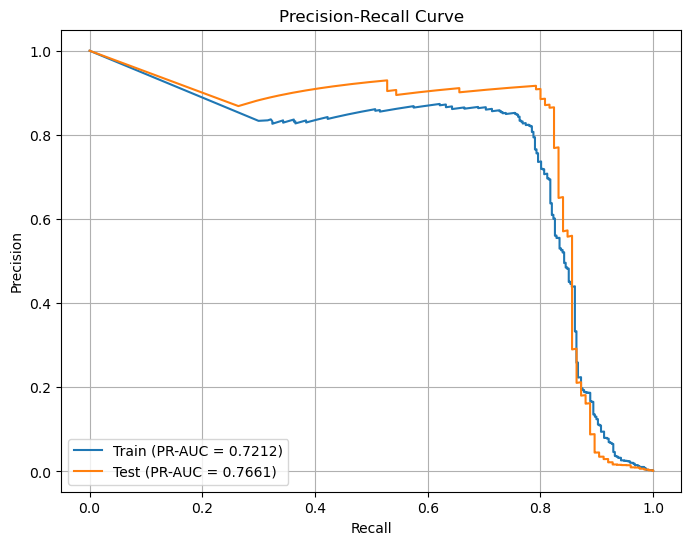

None


In [122]:
logr_model_balanced_eval = evaluate_model(logr_model, X_train, y_train, X_test, y_test)
print(logr_model_balanced_eval)

**Precision = 0.06** - это значит 94% ложных срабатываний, о чем мы и говорили, толку от модели, которая большинство классифицирует как fraud. Для бизнеса это означает, что 94% легит транзакций будут блокироваться либо отправляться на ручную проверку - что неприемлимо.

**Решение проблемы** - поднять порог вероятности пренадлежности к классу.

## Функция для подбора порога вероятности классификации

Наша цель - найти баланс между максимально допустимым recall и приемлимы precision. Для данной задачи отлично подходит метрика **PR-AUC**. Как раз она указана как основная в соревновании на Kagle.

Основная идея функции - нахождение оптимального порога через валидацию  `cross_val_predict()`.

`precision_recall_curve()` - Вычисляет precision и recall для всех возможных порогов.

C помощью `np.argmax(precision + recall)` получаем порог, где precision и recall дают лучший компромисс.

In [58]:
def find_best_threshold(model, X, y, cv):
    """
    Функция для подбора лучшего вероятности порога классификации.
    В качестве метрики подбора используется PR-AUC.
    
    Параметры:
    
    model: обученная модель с методами predict_proba и/или predict
    X_train, y_train: обучающие данные.
    cv: Количество фолдов для кросс-валидации.
    
    """
    # Кросс-валидация для подбора threshold
    y_proba_cv = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y, y_proba_cv)

    # максимизируем сумму precision и recall
    best_threshold = thresholds[np.argmax(precision + recall)]
    
    return best_threshold

## Оценка логистической регрессии с повышенным порогом классификации

TRAIN
Использованный порог: 0.9999972206611072
PR-AUC: 0.7212
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213238
           1       0.85      0.76      0.80       367

    accuracy                           1.00    213605
   macro avg       0.92      0.88      0.90    213605
weighted avg       1.00      1.00      1.00    213605

TEST
Использованный порог: 0.9999972206611072
PR-AUC: 0.7661
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71077
           1       0.89      0.81      0.85       125

    accuracy                           1.00     71202
   macro avg       0.94      0.90      0.92     71202
weighted avg       1.00      1.00      1.00     71202



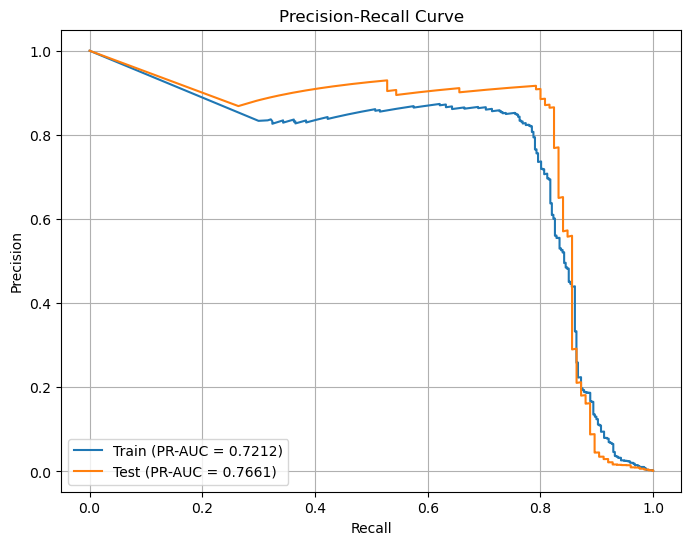

None


In [124]:
logr_model_balanced_eval = evaluate_model(logr_model, X_train, y_train, X_test, y_test, best_threshold)
print(logr_model_balanced_eval)

`PR-AUC` остался на уровне 0.75, но уже лучше ситуация с `precision = 0.89, recall = 0.81`.

Веса для признаков.

In [40]:
coef_logr_model_balanced = logr_model_balanced.coef_
print(f"shape {coef_logr_model_balanced.shape}")
print(coef_logr_model_balanced)

shape (1, 28)
[[ 0.3185901  -0.26256852  0.00897658  0.96440619  0.15243699 -0.29817332
   0.17652607 -0.68042557 -0.35362205 -0.74727868  0.58572037 -0.96017139
  -0.38946742 -1.27507595 -0.08651261 -0.45694355 -0.76350607 -0.351612
   0.17496635  0.1698492   0.28938801  0.43599636 -0.33679581 -0.11517113
   0.08086485 -0.29154506  0.88925878  0.31099447]]


## Обучение на сбалансированных данных (соотношение 1:1)

Создаем датафреймы по классам

In [17]:
fraud = df[df['Class'] == 1].copy()
legit = df[df['Class'] == 0].copy()

Делаем соотношение 1:1, 492 - 25% = 369, значит примеров класса legit должно быть 369.

In [18]:
train_fraud = fraud.sample(n=369, random_state=101, replace=False)
train_legit = legit.sample(n=369, random_state=101, replace=False)

Объединяем датафрейм и перемешиваем данные.

In [20]:
train_df = pd.concat([train_fraud, train_legit], axis=0).sample(frac=1, random_state=101)
train_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
46909,42985.0,-4.075975,0.963031,-5.076070,4.955963,-0.161437,-2.832663,-7.619765,1.618895,-2.992092,-7.142199,6.278666,-9.407061,-1.818874,-10.739572,0.224206,-8.427083,-13.502153,-4.712968,2.630476,0.058861,1.030738,0.165328,-1.017502,-0.477983,-0.304987,-0.106089,1.899714,0.511462,1.00,1
30100,35771.0,-3.218952,2.708535,-3.263042,1.361866,-1.645776,-1.852982,-3.069958,-1.796876,-0.213356,-3.551984,3.779750,-6.984771,-1.140977,-9.377878,0.921464,-4.652071,-9.094231,-3.082550,0.132331,0.571654,1.807877,-0.890421,-0.325814,0.123040,-0.093014,0.232106,-0.310519,-0.745295,60.60,1
149874,92102.0,-1.662937,3.253892,-7.040485,2.266456,-4.177649,-0.746925,-0.248337,1.091157,-0.307137,-5.567947,2.712739,-5.948403,2.144726,-4.211756,-0.137196,-2.639409,-2.532355,-0.667067,0.626059,-0.842178,0.450381,0.521162,0.308325,-0.318012,-1.255362,-0.691963,0.264878,-0.130445,600.73,1
238850,149851.0,2.042251,0.030738,-2.544714,-0.305762,0.482223,-1.991683,0.863793,-0.677279,0.343459,-0.707376,-0.197239,0.592216,0.668139,-0.817478,-0.080565,-0.468064,0.945495,-0.406042,0.312341,-0.013308,0.062671,0.344489,-0.100804,0.082986,0.322808,1.065954,-0.129379,-0.053812,57.16,0
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249167,154278.0,-1.600211,-3.488130,-6.459303,3.246816,-1.614608,-1.260375,0.288223,-0.048964,-0.734975,-4.441484,2.944375,-3.805469,-2.102227,-6.106183,-0.641736,-1.555963,-2.084067,0.394247,0.083380,3.189355,1.191175,-0.967141,-1.463421,-0.624231,-0.176462,0.400348,0.152947,0.477775,1504.93,1
128354,78683.0,-1.680974,1.111344,0.109021,1.211140,-3.163950,1.521364,0.641945,1.218147,-0.191580,-0.997083,-0.144409,0.975615,-0.277470,0.593740,-1.034806,0.278961,0.253088,0.732095,1.171120,-0.627419,0.045268,0.244088,0.203288,0.027320,-0.769758,-0.523261,-0.083962,-0.163129,424.94,0
48719,43758.0,1.047524,-0.230414,0.213037,0.187534,-0.582802,-1.087910,0.295368,-0.333135,-0.029119,-0.226166,-0.051994,0.750911,1.083336,0.103455,0.911698,0.222486,-0.337826,-0.754875,0.051176,0.247551,-0.141403,-0.653206,-0.013968,0.451626,0.161358,0.798703,-0.102857,0.029379,130.95,0
150665,93856.0,-6.750509,5.367416,-10.054635,9.064478,-7.968118,-2.263798,-10.317566,4.237666,-5.324109,-11.092392,7.154083,-17.150405,-0.095399,-11.030110,-1.959055,-12.448562,-22.667905,-9.264609,1.982356,-0.081220,1.909032,-0.348740,0.425001,0.674909,-0.784208,-0.247422,1.159581,0.197818,209.65,1


Удаляем по индексам из тестового датафрейма те объекты, которые попали в трейн.

In [25]:
test_fraud = fraud.drop(train_fraud.index)
test_legit = legit.drop(train_legit.index)
test_df = pd.concat([test_fraud, test_legit], axis=0)
test_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6331,7526.0,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,-6.187891,5.664395,-9.854485,-0.306167,-10.691196,-0.638498,-2.041974,-1.129056,0.116453,-1.934666,0.488378,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1
6336,7543.0,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,-2.214311,-5.134454,4.560720,-8.873748,-0.797484,-9.177166,-0.257025,-0.871688,1.313014,0.773914,-2.370599,0.269773,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1.00,1
6446,7672.0,0.702710,2.426433,-5.234513,4.416661,-2.170806,-2.667554,-3.878088,0.911337,-0.166199,-5.009249,4.675729,-8.167188,0.638559,-6.763334,1.296860,-3.811758,-3.754128,-1.049177,1.554197,0.422743,0.551180,-0.009802,0.721698,0.473246,-1.959304,0.319476,0.600485,0.129305,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Проверка пересечения:
train_indices & test_indices возвращает общие элементы (индексы, которые есть и в train, и в test).

len() - считает количество таких элементов.

assert - проверяет, что это количество равно 0. Если нет - вызывает ошибку.

In [26]:
train_indices = set(train_df.index)
test_indices = set(test_df.index)
assert len(train_indices & test_indices) == 0, "Обнаружены пересекающиеся индексы!"

In [36]:
X_train_balanced, y_train_balanced = train_df.drop(['Time', 'Amount', 'Class'], axis=1), train_df['Class']
X_test_balanced, y_test_balanced = test_df.drop(['Time', 'Amount', 'Class'], axis=1), test_df['Class']

In [33]:
X_train_balanced

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
46909,-4.075975,0.963031,-5.076070,4.955963,-0.161437,-2.832663,-7.619765,1.618895,-2.992092,-7.142199,6.278666,-9.407061,-1.818874,-10.739572,0.224206,-8.427083,-13.502153,-4.712968,2.630476,0.058861,1.030738,0.165328,-1.017502,-0.477983,-0.304987,-0.106089,1.899714,0.511462
30100,-3.218952,2.708535,-3.263042,1.361866,-1.645776,-1.852982,-3.069958,-1.796876,-0.213356,-3.551984,3.779750,-6.984771,-1.140977,-9.377878,0.921464,-4.652071,-9.094231,-3.082550,0.132331,0.571654,1.807877,-0.890421,-0.325814,0.123040,-0.093014,0.232106,-0.310519,-0.745295
149874,-1.662937,3.253892,-7.040485,2.266456,-4.177649,-0.746925,-0.248337,1.091157,-0.307137,-5.567947,2.712739,-5.948403,2.144726,-4.211756,-0.137196,-2.639409,-2.532355,-0.667067,0.626059,-0.842178,0.450381,0.521162,0.308325,-0.318012,-1.255362,-0.691963,0.264878,-0.130445
238850,2.042251,0.030738,-2.544714,-0.305762,0.482223,-1.991683,0.863793,-0.677279,0.343459,-0.707376,-0.197239,0.592216,0.668139,-0.817478,-0.080565,-0.468064,0.945495,-0.406042,0.312341,-0.013308,0.062671,0.344489,-0.100804,0.082986,0.322808,1.065954,-0.129379,-0.053812
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249167,-1.600211,-3.488130,-6.459303,3.246816,-1.614608,-1.260375,0.288223,-0.048964,-0.734975,-4.441484,2.944375,-3.805469,-2.102227,-6.106183,-0.641736,-1.555963,-2.084067,0.394247,0.083380,3.189355,1.191175,-0.967141,-1.463421,-0.624231,-0.176462,0.400348,0.152947,0.477775
128354,-1.680974,1.111344,0.109021,1.211140,-3.163950,1.521364,0.641945,1.218147,-0.191580,-0.997083,-0.144409,0.975615,-0.277470,0.593740,-1.034806,0.278961,0.253088,0.732095,1.171120,-0.627419,0.045268,0.244088,0.203288,0.027320,-0.769758,-0.523261,-0.083962,-0.163129
48719,1.047524,-0.230414,0.213037,0.187534,-0.582802,-1.087910,0.295368,-0.333135,-0.029119,-0.226166,-0.051994,0.750911,1.083336,0.103455,0.911698,0.222486,-0.337826,-0.754875,0.051176,0.247551,-0.141403,-0.653206,-0.013968,0.451626,0.161358,0.798703,-0.102857,0.029379
150665,-6.750509,5.367416,-10.054635,9.064478,-7.968118,-2.263798,-10.317566,4.237666,-5.324109,-11.092392,7.154083,-17.150405,-0.095399,-11.030110,-1.959055,-12.448562,-22.667905,-9.264609,1.982356,-0.081220,1.909032,-0.348740,0.425001,0.674909,-0.784208,-0.247422,1.159581,0.197818


In [37]:
X_test_balanced

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573
6331,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,-6.187891,5.664395,-9.854485,-0.306167,-10.691196,-0.638498,-2.041974,-1.129056,0.116453,-1.934666,0.488378,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574
6336,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,-2.214311,-5.134454,4.560720,-8.873748,-0.797484,-9.177166,-0.257025,-0.871688,1.313014,0.773914,-2.370599,0.269773,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474
6446,0.702710,2.426433,-5.234513,4.416661,-2.170806,-2.667554,-3.878088,0.911337,-0.166199,-5.009249,4.675729,-8.167188,0.638559,-6.763334,1.296860,-3.811758,-3.754128,-1.049177,1.554197,0.422743,0.551180,-0.009802,0.721698,0.473246,-1.959304,0.319476,0.600485,0.129305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533


In [32]:
y_train_balanced

46909     1
30100     1
149874    1
238850    0
6329      1
         ..
249167    1
128354    0
48719     0
150665    1
130770    0
Name: Class, Length: 738, dtype: int64

In [39]:
y_test_balanced

541       1
6108      1
6331      1
6336      1
6446      1
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284069, dtype: int64

In [46]:
logr_model_balanced_train = LogisticRegression(
        class_weight='balanced',
        n_jobs=-1,
        max_iter=150
)

In [47]:
logr_model_balanced_train.fit(X_train_balanced, y_train_balanced)

LogisticRegression(class_weight='balanced', max_iter=150, n_jobs=-1)

TRAIN
Использованный порог: 0.995
PR-AUC: 0.9904
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       369
           1       1.00      0.78      0.88       369

    accuracy                           0.89       738
   macro avg       0.91      0.89      0.89       738
weighted avg       0.91      0.89      0.89       738

TEST
Использованный порог: 0.995
PR-AUC: 0.1026
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    283946
           1       0.07      0.80      0.14       123

    accuracy                           1.00    284069
   macro avg       0.54      0.90      0.57    284069
weighted avg       1.00      1.00      1.00    284069



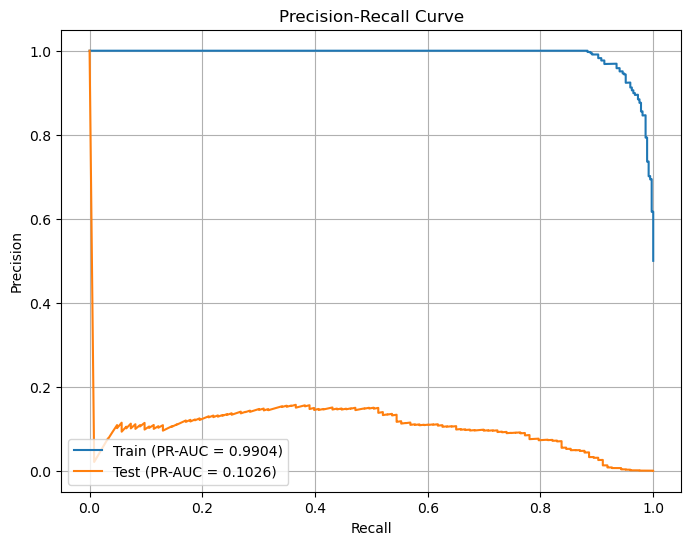

None


In [52]:
logr_eval_balanced = evaluate_model(logr_model_balanced_train, X_train_balanced, y_train_balanced, X_test_balanced, y_test_balanced, 0.995)
print(logr_eval_balanced)

Решение `сбалансировать данные уменьшением выборки` - оказалось неэффективным.

## Вывод: 
  -  Логистическая регрессия в совокупности методов, взвешивания классов и поднятия порога классификации - дает хороший результат при **критическом дисбалансе(280к - legit, 492 - fraud)** и **маленьком наборе данных (поток транзакций всего 50ч) для супер масштабной задачи**. Модель свое отработала!

## Результаты модели до

**PR-AUC**: `0.7892`  

| Класс | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| Legit | 1.00      | 1.00   | 1.00     | 71,077  |
| Fraud | 0.88      | 0.62   | 0.72     | 125     |

## Результаты модели после

**PR-AUC**: `0.7661`  

| Класс | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| Legit | 1.00      | 1.00   | 1.00     | 71,077  |
| Fraud | 0.89      | 0.81   | 0.85     | 125     |


-------
### За счет небольшой потери `PR-AUC (3%)`, **увеличен** `recall на 24%`.